In [235]:
from quaternions import *
from networks import *
from helpers_sim import *
from liegroups.numpy import SO3
import torch
from convex_layers import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 90

In [260]:
path = 'saved_data/synthetic/synthetic_wahba_model_A_sym_12-31-2019-12-58-29.pt'

#PSD
#path = 'saved_data/synthetic/synthetic_wahba_model_A_sym_12-31-2019-14-28-46.pt'
checkpoint = torch.load(path)
args = checkpoint['args']
print(args)
device = torch.device('cpu')
tensor_type = torch.double
model = QuatNet(enforce_psd=args.enforce_psd, unit_frob_norm=True).to(device=device, dtype=tensor_type)
print('Loading data...')
model.load_state_dict(checkpoint['model'], strict=False)
print('Done')

Namespace(N_test=100, N_train=500, batch_size_test=100, batch_size_train=100, beachball_sigma_factors=[0.1, 0.5, 2, 10], cuda=False, dataset='dynamic', double=False, enforce_psd=False, epochs=250, lr=0.0005, matches_per_sample=100, model='A_sym', save_model=True, sim_sigma=0.01)
Loading data...
Done


In [261]:
train_data, test_data = create_experimental_data(5, 500, args.matches_per_sample, sigma=args.sim_sigma, device=device, dtype=tensor_type)

In [262]:
def l2_diff(a, b):
    return (a - b).norm(dim=1)
def acos_diff(a, b):
    a = a / a.norm(dim=1, keepdim=True)
    b = b / b.norm(dim=1, keepdim=True)
    return (180./3.1415)*torch.acos((a*b).sum(dim=1, keepdim=True)).squeeze()

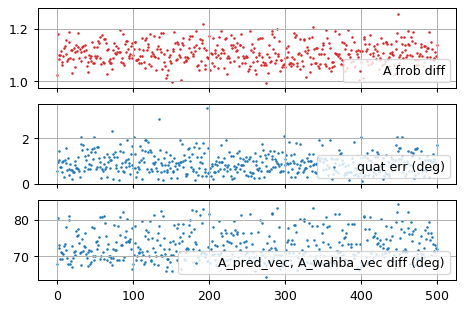

In [276]:
def _scatter(ax, x, y, title, color='tab:red', marker=".", size=4):
    ax.scatter(x, y, color=color, s=size, marker=marker, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return
def _scatter3D(ax, x, y, z, title, color='tab:red', marker=".", size=4):
    ax.scatter(x, y, z, color=color, s=size, marker=marker, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return
qcqp_solver = QuadQuatFastSolver.apply

model.eval()
i = torch.arange(0,test_data.x.shape[0])
with torch.no_grad():
    A_pred = model.output_A(test_data.x[i])
    q_est = model.forward(test_data.x[i]).squeeze()
    
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row')

A_wahba = test_data.A_prior
A_wahba = A_wahba / A_wahba.norm(dim=[1,2], keepdim=True)

A_pred_vec = convert_A_to_Avec(A_pred)
A_wahba_vec = convert_A_to_Avec(A_wahba)


A_rand_vec = normalize_Avec(torch.randn(A_pred.shape[0], 10))
A_rand = convert_Avec_to_A(A_rand_vec)

_scatter(ax[0], i, (A_pred - A_wahba).norm(dim=[1,2]).numpy(), 'A frob diff', color='tab:red')
_scatter(ax[1], i, quat_angle_diff(q_est, test_data.q, reduce=False).numpy(), 'quat err (deg)', color='tab:blue')
_scatter(ax[2], i, acos_diff(A_pred_vec, A_wahba_vec).numpy(), 'A_pred_vec, A_wahba_vec diff (deg)', color='tab:blue')

plt.show()

# print(q_est[:1])
# print(qcqp_solver(A_pred_vec[:2]))
# print(test_data.q[:2])
# print(qcqp_solver(A_wahba_vec[:2]))

# print(convert_Avec_to_A(A_pred_vec[0]))
# print(convert_Avec_to_A(A_wahba_vec[0]))


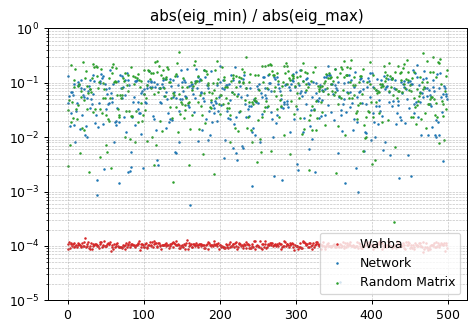

In [264]:
def eig_ratio(A):
    el, ev = np.linalg.eig(A)
    return np.abs(el).min(axis=1) / np.abs(el).max(axis=1)


vec_rand = torch.rand(A_pred.shape[0], 10)
if args.enforce_psd:
    vec_rand = convert_Avec_to_Avec_psd(vec_rand)
vec_rand = normalize_Avec(vec_rand)
A_rand = convert_Avec_to_A(vec_rand)


fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, np.arange(A_pred.shape[0]), eig_ratio(A_wahba.numpy()), 'Wahba', color='tab:red')
_scatter(ax, np.arange(A_pred.shape[0]), eig_ratio(A_pred.numpy()), 'Network', color='tab:blue')
_scatter(ax, np.arange(A_pred.shape[0]), eig_ratio(A_rand.numpy()), 'Random Matrix', color='tab:green')
ax.set_title('abs(eig_min) / abs(eig_max)')
ax.set_yscale('log')
ax.set_ylim([1e-5, 1])
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)

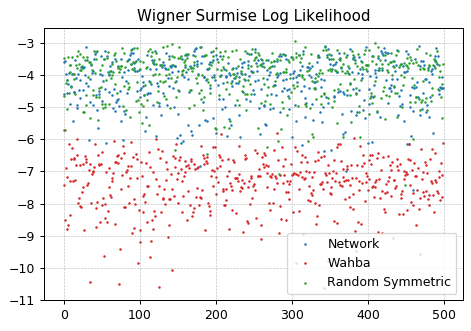

In [265]:
#Random matrix:

# vec_rand = normalize_Avec(convert_Avec_to_Avec_psd(torch.rand(2, 10)))
# A_rand = convert_Avec_to_A(vec_rand)
# el, ev = np.linalg.eig(A_rand.numpy())
# print(el)
# el, ev = np.linalg.eig(A_pred[1].numpy())
# print(el)

def wigner_log_likelihood(A):
    el, _ = np.linalg.eig(A)
    el.sort(axis=1)
    spacings = np.diff(el, axis=1)
    lls = np.log(spacings) - 0.25*np.pi*(spacings**2)
    return np.sum(lls, axis=1)

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, np.arange(A_pred.shape[0]), wigner_log_likelihood(A_pred.numpy()), 'Network', color='tab:blue')
_scatter(ax, np.arange(A_pred.shape[0]), wigner_log_likelihood(A_wahba.numpy()), 'Wahba', color='tab:red')
_scatter(ax, np.arange(A_pred.shape[0]), wigner_log_likelihood(A_rand.numpy()), 'Random Symmetric', color='tab:green')
ax.set_title('Wigner Surmise Log Likelihood')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)

#print(np.linalg.eig(test_data.A_prior[15].numpy()))
#print(ev)

Text(0.5, 0, 'First eigenvalue')

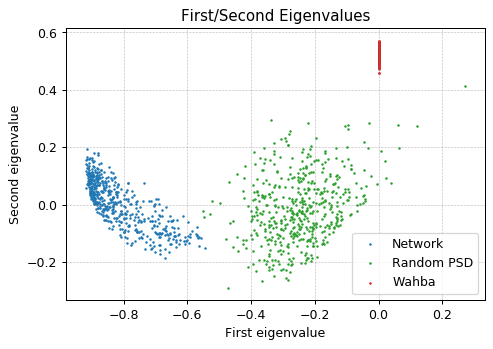

In [266]:
def sorted_els(A):
    el, _ = np.linalg.eig(A)
    el.sort(axis=1)
    return el

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, sorted_els(A_pred.numpy())[:,0], sorted_els(A_pred.numpy())[:,1], 'Network', color='tab:blue')
_scatter(ax, sorted_els(A_rand.numpy())[:,0], sorted_els(A_rand.numpy())[:,1], 'Random PSD', color='tab:green')
_scatter(ax, sorted_els(A_wahba.numpy())[:,0], sorted_els(A_wahba.numpy())[:,1], 'Wahba', color='tab:red')

ax.set_title('First/Second Eigenvalues')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Second eigenvalue')
ax.set_xlabel('First eigenvalue')

Text(0.5, 0, 'First eigenvalue')

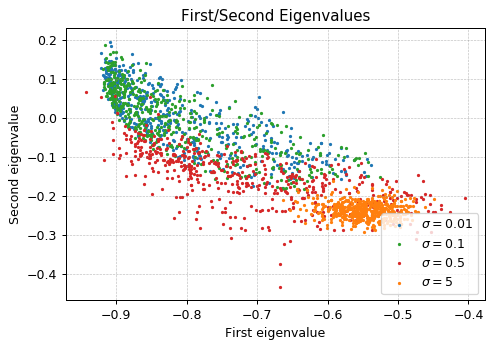

In [269]:
N = 500
_, test_data0 = create_experimental_data(5, N, args.matches_per_sample, sigma=args.sim_sigma, device=device, dtype=tensor_type)
_, test_data1 = create_experimental_data_fast(5, N, args.matches_per_sample, sigma=0.1, device=device, dtype=tensor_type)
_, test_data2 = create_experimental_data_fast(5, N, args.matches_per_sample, sigma=0.5, device=device, dtype=tensor_type)
_, test_data3 = create_experimental_data_fast(5, N, args.matches_per_sample, sigma=5, device=device, dtype=tensor_type)

with torch.no_grad():
    A_0 = model.output_A(test_data0.x)
    A_1 = model.output_A(test_data1.x)
    A_2 = model.output_A(test_data2.x)
    A_3 = model.output_A(test_data3.x)
    
    
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, sorted_els(A_0.numpy())[:,0], sorted_els(A_0.numpy())[:,1], '$\sigma = 0.01$', color='tab:blue', size=10)
_scatter(ax, sorted_els(A_1.numpy())[:,0], sorted_els(A_1.numpy())[:,1], '$\sigma = 0.1$', color='tab:green', size=10)
_scatter(ax, sorted_els(A_2.numpy())[:,0], sorted_els(A_2.numpy())[:,1], '$\sigma = 0.5$', color='tab:red', size=10)
_scatter(ax, sorted_els(A_3.numpy())[:,0], sorted_els(A_3.numpy())[:,1], '$\sigma = 5$', color='tab:orange',size=10)

ax.set_title('First/Second Eigenvalues')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Second eigenvalue')
ax.set_xlabel('First eigenvalue')

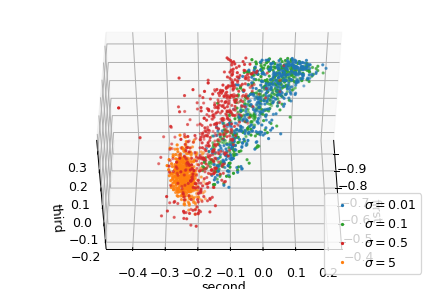

In [288]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
_scatter3D(ax, sorted_els(A_0.numpy())[:,0], sorted_els(A_0.numpy())[:,1], sorted_els(A_0.numpy())[:,2], '$\sigma = 0.01$', color='tab:blue', size=10)
_scatter3D(ax, sorted_els(A_1.numpy())[:,0], sorted_els(A_1.numpy())[:,1], sorted_els(A_1.numpy())[:,2], '$\sigma = 0.1$', color='tab:green', size=10)
_scatter3D(ax, sorted_els(A_2.numpy())[:,0], sorted_els(A_2.numpy())[:,1], sorted_els(A_2.numpy())[:,2], '$\sigma = 0.5$', color='tab:red', size=10)
_scatter3D(ax, sorted_els(A_3.numpy())[:,0], sorted_els(A_3.numpy())[:,1], sorted_els(A_3.numpy())[:,2], '$\sigma = 5$', color='tab:orange', size=10)
ax.set_xlabel('first')
ax.set_ylabel('second')
ax.set_zlabel('third')

ax.view_init(45, 0)


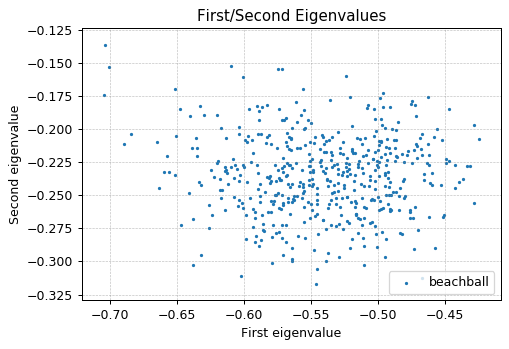

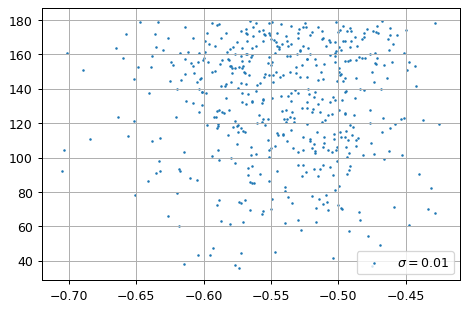

In [298]:
beachball = True
beachball_factors = [0.1, 1., 10, 1000]
_, test_data_bb = create_experimental_data_fast(5, 500, args.matches_per_sample, sigma=args.sim_sigma, beachball=beachball, beachball_factors=beachball_factors, device=device, dtype=tensor_type)
with torch.no_grad():
    A_bb = model.output_A(test_data_bb.x)
    q_bb = model.forward(test_data_bb.x)

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, sorted_els(A_bb.numpy())[:,0], sorted_els(A_bb.numpy())[:,1], 'beachball', color='tab:blue', size=10)
ax.set_title('First/Second Eigenvalues')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Second eigenvalue')
ax.set_xlabel('First eigenvalue')

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, sorted_els(A_bb.numpy())[:,0], quat_angle_diff(q_bb, test_data_bb.q, reduce=False).numpy(), '$\sigma = 0.01$', color='tab:blue')



(0, 25)

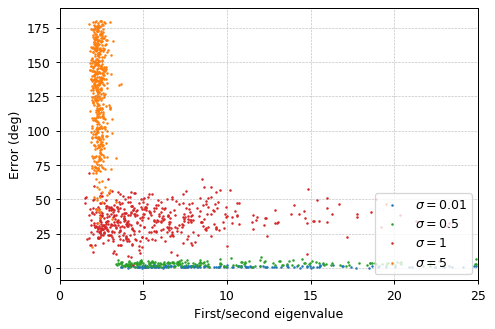

In [273]:
def _arrows(ax, eigs, title, color='tab:red'):
    for e in eigs:
        ax.arrow(e[0], e[1], e[2] - e[0], e[3] - e[1], color=color, label=title)
    return

# fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
# ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
# _arrows(ax, sorted_els(A_0.numpy()), '$\sigma = 0.01$', color='tab:blue')
# _arrows(ax, sorted_els(A_1.numpy()), '$\sigma = 0.05$', color='tab:green')
# _arrows(ax, sorted_els(A_2.numpy()), '$\sigma = 0.1$', color='tab:red')
# _arrows(ax, sorted_els(A_3.numpy()), '$\sigma = 5$', color='tab:orange')
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])


# plt.rcParams['figure.dpi'] = 150
# fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
# ax.set_title('Eigenvalues')
# _scatter(ax, sorted_els(A_0.numpy())[:,0], sorted_els(A_0.numpy())[:,1], '$\sigma = 0.01, 1,2$', color='tab:blue', marker='o', size=10)
# _scatter(ax, sorted_els(A_0.numpy())[:,2], sorted_els(A_0.numpy())[:,3], '$\sigma = 0.01$', color='tab:blue', marker='x', size=10)

# _scatter(ax, sorted_els(A_1.numpy())[:,0], sorted_els(A_1.numpy())[:,1], '$\sigma = 0.05$', color='tab:green', marker='o', size=10)
# _scatter(ax, sorted_els(A_1.numpy())[:,2], sorted_els(A_1.numpy())[:,3], '$\sigma = 0.05$', color='tab:green', marker='x', size=10)

# _scatter(ax, sorted_els(A_2.numpy())[:,0], sorted_els(A_2.numpy())[:,1], '$\sigma = 0.1$', color='tab:red', marker='o', size=10)
# _scatter(ax, sorted_els(A_2.numpy())[:,2], sorted_els(A_2.numpy())[:,3], '$\sigma = 0.1$', color='tab:red', marker='x', size=10)

# _scatter(ax, sorted_els(A_3.numpy())[:,0], sorted_els(A_3.numpy())[:,1], '$\sigma = 1$', color='tab:orange', marker='o', size=10)
# _scatter(ax, sorted_els(A_3.numpy())[:,2], sorted_els(A_3.numpy())[:,3], '$\sigma = 1$', color='tab:orange', marker='x', size=10)

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)

with torch.no_grad():
    q_0 = model.forward(test_data0.x)
    q_1 = model.forward(test_data1.x)
    q_2 = model.forward(test_data2.x)
    q_3 = model.forward(test_data3.x)

_scatter(ax, sorted_els(A_0.numpy())[:,0] / sorted_els(A_0.numpy())[:,1], quat_angle_diff(q_0, test_data0.q, reduce=False).numpy(), '$\sigma = 0.01$', color='tab:blue')
_scatter(ax, sorted_els(A_1.numpy())[:,0] / sorted_els(A_1.numpy())[:,1], quat_angle_diff(q_1, test_data1.q, reduce=False).numpy(), '$\sigma = 0.5$', color='tab:green')
_scatter(ax, sorted_els(A_2.numpy())[:,0] / sorted_els(A_2.numpy())[:,1], quat_angle_diff(q_2, test_data2.q, reduce=False).numpy(), '$\sigma = 1$', color='tab:red')
_scatter(ax, sorted_els(A_3.numpy())[:,0] / sorted_els(A_3.numpy())[:,1], quat_angle_diff(q_3, test_data3.q, reduce=False).numpy(), '$\sigma = 5$', color='tab:orange')

# _scatter(ax, sorted_els(A_1.numpy())[:,0], quat_angle_diff(q_1, test_data1.q, reduce=False).numpy(), '$\sigma = 0.1$', color='tab:green')
# _scatter(ax, sorted_els(A_2.numpy())[:,0], quat_angle_diff(q_2, test_data2.q, reduce=False).numpy(), '$\sigma = 0.5$', color='tab:red')
# _scatter(ax, sorted_els(A_3.numpy())[:,0], quat_angle_diff(q_3, test_data3.q, reduce=False).numpy(), '$\sigma = 5$', color='tab:orange')
ax.set_xlabel('First/second eigenvalue')
ax.set_ylabel('Error (deg)')
ax.set_xlim([0,25])

In [27]:
matches = 36
sigma = 1e-10
#sigma_vec = sigma*np.random.randn(matches)
sigma_vec = sigma*np.ones(matches)

#sigma_vec[:int(matches/2)] *= np.random.randn(int(matches/2)) #Artificially scale half the noise

C, x_1, x_2 = gen_sim_data_grid(matches, sigma_vec, torch_vars=False, shuffle_points=False)
#print(x_1)
A = build_A(x_1, x_2, sigma_2=sigma_vec**2)
A = A/np.linalg.norm(A)
el, ev = np.linalg.eig(A)
print(el)
print(ev)
print(np.linalg.matrix_rank(A))

[-1.11022302e-16  8.12139053e-01  3.60081960e-01  4.59098182e-01]
[[ 0.1650793  -0.17406694 -0.89981441  0.36439477]
 [-0.68094376 -0.3713238  -0.28182285 -0.5648098 ]
 [ 0.40255702 -0.88416681  0.23605136 -0.02183244]
 [-0.58907747 -0.22375967  0.2349248   0.74008762]]
3


In [ ]:
matches = 16
C = SO3.exp(np.random.randn(3)).as_matrix()
#v = normalized(np.random.randn(1, 3))
#x_1 = np.concatenate((v, v))
x_1 = normalized(np.random.randn(matches, 3))
x_2 = C.dot(x_1.T).T 
A = build_A(x_1, x_2, sigma_2=np.ones(matches))
A = A / np.linalg.norm(A)

print(A)
el, ev = np.linalg.eig(A)
print(el)
#print(ev)
print(np.linalg.det(A))
print(np.linalg.matrix_rank(A))

# B = 4*np.eye(4) + 2*Omega_l(pure_quat(x_2[0])).dot(
#             Omega_r(pure_quat(x_1[0]))) + 2*Omega_l(pure_quat(x_2[1])).dot(
#             Omega_r(pure_quat(x_1[1])))
# B = B / np.linalg.norm(B)
# print(B)
# print(np.linalg.eig(B))


In [ ]:
matches = 100
C, x_1, x_2 = gen_sim_data(matches, 1e-1*np.ones(matches), torch_vars=True, shuffle_points=True)
x = torch.empty(1, 2, matches, 3, dtype=torch.double)
x[0,0,:,:] = x_1
x[0,1,:,:] = x_2
q_est = model.forward(x).squeeze()
q_gt = rotmat_to_quat(C, ordering='xyzw')
print(quat_angle_diff(q_est, q_gt))

C_horn = solve_horn(x_1.numpy(), x_2.numpy())
print(quat_angle_diff(rotmat_to_quat(torch.from_numpy(C_horn), ordering='xyzw'), q_gt))

In [ ]:
convert_Avec_to_A(torch.arange(10))

In [ ]:
from numpy import pi, cos, sin, arccos, arange
import mpl_toolkits.mplot3d
import matplotlib.pyplot as pp
%matplotlib inline
pp.rcParams['figure.dpi'] = 300

num_pts = 1000
indices = arange(0, num_pts, dtype=float) + 0.5

phi = arccos(1 - 2*indices/num_pts)
theta = pi * (1 + 5**0.5) * indices

x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi);

pp.figure().add_subplot(111, projection='3d').scatter(x, y, z, s=1.);
pp.show()

In [ ]:
import torch
num_pts = 10000
pts = torch.randn(3, num_pts)
pts = pts / pts.norm(dim=0, keepdim=True)
region_masks = [(pts[0] < 0.) & (pts[1] < 0.), 
                (pts[0] >= 0.) & (pts[1] < 0.), 
                (pts[0] < 0.) & (pts[1] >= 0.), 
                (pts[0] >= 0.) & (pts[1] >= 0.)]
ax = pp.figure().add_subplot(111, projection='3d')

colours = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange']
labels = ['$0.25 \sigma$','$0.5 \sigma$','$2 \sigma$','$4 \sigma$']
for m_i, mask in enumerate(region_masks):
    ax.scatter(pts[0, mask].numpy(), pts[1, mask].numpy(), pts[2, mask].numpy(), s=1., c=colours[m_i], label=labels[m_i])
ax.legend()
ax.grid(which='both')
ax.set_yticks(torch.arange(-1, 1.1, step=0.5))
ax.set_xticks(torch.arange(-1, 1.1, step=0.5))
ax.set_zticks(torch.arange(-1, 1.1, step=0.5))

pp.show()